In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
df = pd.read_csv('data/course_lead_scoring.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
# Check data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing values per column:
lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64

Total missing values: 606


In [5]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from the lists if present
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [6]:
# Handle missing values
# For categorical features, replace with 'NA'
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

# For numerical features, replace with 0.0
for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

# Verify no missing values remain
print(f"Missing values after handling: {df.isnull().sum().sum()}")

Missing values after handling: 0


In [7]:
# Split the data into train/validation/test with 60%/20%/20% distribution
# First, separate features and target
X = df.drop('converted', axis=1)
y = df['converted']

# First split: 60% train, 40% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1
)

# Second split: split the 40% into 20% validation and 20% test (50/50 of the temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

print(f"Train set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nTotal: {len(X_train) + len(X_val) + len(X_test)}")

Train set size: 877 (60.0%)
Validation set size: 292 (20.0%)
Test set size: 293 (20.0%)

Total: 1462


In [8]:
# Verify the target distribution across splits
print("Target distribution:")
print(f"Train - converted rate: {y_train.mean():.4f}")
print(f"Validation - converted rate: {y_val.mean():.4f}")
print(f"Test - converted rate: {y_test.mean():.4f}")

Target distribution:
Train - converted rate: 0.6078
Validation - converted rate: 0.6575
Test - converted rate: 0.6143


## Question 1: ROC AUC Feature Importance

Compute ROC AUC for each numerical variable to evaluate feature importance.

In [9]:
from sklearn.metrics import roc_auc_score

# Variables to evaluate
variables = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Compute ROC AUC for each variable using training data
auc_scores = {}

for var in variables:
    # Use the variable as the prediction score
    predictions = X_train[var]
    
    # Compute AUC
    auc = roc_auc_score(y_train, predictions)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -predictions)
        print(f"{var}: {auc:.4f} (inverted)")
        auc_scores[var] = auc
    else:
        print(f"{var}: {auc:.4f}")
        auc_scores[var] = auc

# Find the variable with highest AUC
best_var = max(auc_scores, key=auc_scores.get)
print(f"\nHighest AUC: {best_var} with AUC = {auc_scores[best_var]:.4f}")

lead_score: 0.6111
number_of_courses_viewed: 0.7652
interaction_count: 0.7272
annual_income: 0.5446

Highest AUC: number_of_courses_viewed with AUC = 0.7652


## Question 2: Training the model

Apply one-hot encoding using DictVectorizer and train logistic regression.

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Convert dataframes to dictionaries for DictVectorizer
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

print(f"Original training features: {X_train.shape[1]}")
print(f"Encoded training features: {X_train_encoded.shape[1]}")

# Train logistic regression model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Make predictions on validation set
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

# Calculate AUC on validation dataset
auc_val = roc_auc_score(y_val, y_val_pred)
print(f"\nAUC on validation dataset: {auc_val:.3f}")

Original training features: 8
Encoded training features: 31

AUC on validation dataset: 0.794


### Question 3: Precision and Recall

Compute precision and recall for all thresholds from 0.0 to 1.0 with step 0.01

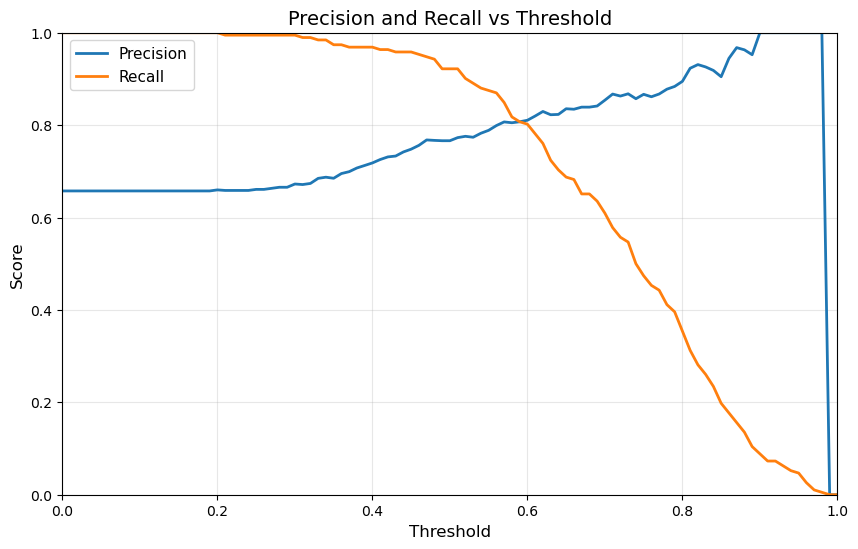

Precision and Recall intersect at threshold: 0.590
At this threshold:
  Precision: 0.807
  Recall: 0.807


In [11]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Define thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

# Compute precision and recall for each threshold
for threshold in thresholds:
    # Apply threshold to predicted probabilities
    y_pred_threshold = (y_val_pred >= threshold).astype(int)
    
    # Handle edge cases where there are no positive predictions
    if y_pred_threshold.sum() == 0:
        precision = 0
    else:
        precision = precision_score(y_val, y_pred_threshold, zero_division=0)
    
    recall = recall_score(y_val, y_pred_threshold, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Convert to arrays for easier manipulation
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Find the intersection point
# Calculate the absolute difference between precision and recall
diff = np.abs(precisions - recalls)
# Find the index of minimum difference
intersection_idx = np.argmin(diff)
intersection_threshold = thresholds[intersection_idx]

print(f"Precision and Recall intersect at threshold: {intersection_threshold:.3f}")
print(f"At this threshold:")
print(f"  Precision: {precisions[intersection_idx]:.3f}")
print(f"  Recall: {recalls[intersection_idx]:.3f}")

In [12]:
# Let's check the specific thresholds from the answer options
answer_options = [0.145, 0.345, 0.545, 0.745]

print("Values at answer option thresholds:")
for opt in answer_options:
    idx = np.argmin(np.abs(thresholds - opt))
    print(f"\nThreshold {opt}:")
    print(f"  Precision: {precisions[idx]:.3f}")
    print(f"  Recall: {recalls[idx]:.3f}")
    print(f"  Difference: {abs(precisions[idx] - recalls[idx]):.3f}")

# Find the closest match from the answer options
best_option = None
min_diff = float('inf')
for opt in answer_options:
    idx = np.argmin(np.abs(thresholds - opt))
    diff = abs(precisions[idx] - recalls[idx])
    if diff < min_diff:
        min_diff = diff
        best_option = opt

print(f"\nClosest answer option to intersection: {best_option}")

Values at answer option thresholds:

Threshold 0.145:
  Precision: 0.658
  Recall: 1.000
  Difference: 0.342

Threshold 0.345:
  Precision: 0.687
  Recall: 0.984
  Difference: 0.297

Threshold 0.545:
  Precision: 0.782
  Recall: 0.880
  Difference: 0.098

Threshold 0.745:
  Precision: 0.857
  Recall: 0.500
  Difference: 0.357

Closest answer option to intersection: 0.545


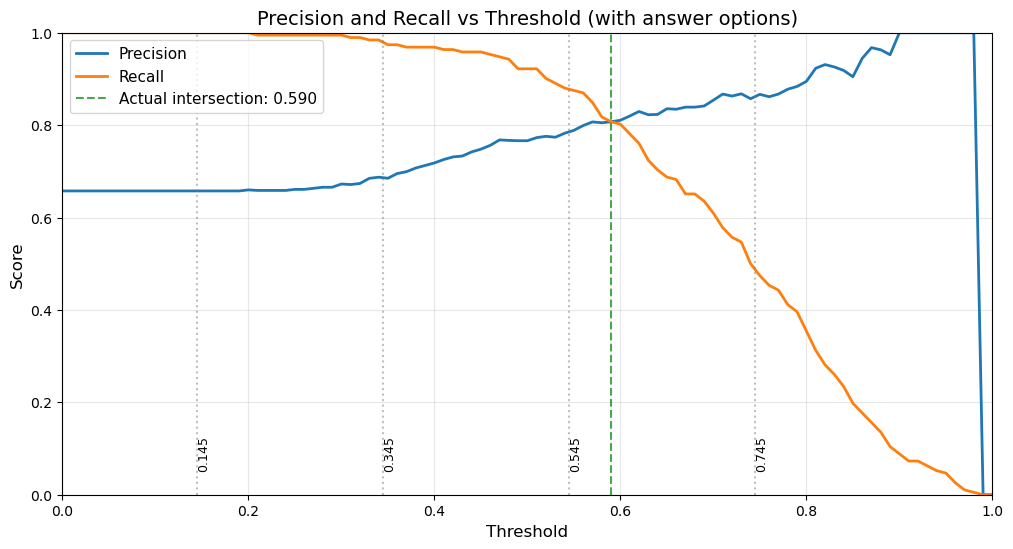


ANSWER: The precision and recall curves intersect closest to 0.545


In [13]:
# Create a zoomed-in plot around the intersection
plt.figure(figsize=(12, 6))

# Plot the curves
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)

# Mark the actual intersection
plt.axvline(x=intersection_threshold, color='green', linestyle='--', 
            alpha=0.7, label=f'Actual intersection: {intersection_threshold:.3f}')

# Mark the answer options
for opt in answer_options:
    plt.axvline(x=opt, color='gray', linestyle=':', alpha=0.5)
    plt.text(opt, 0.05, f'{opt}', rotation=90, verticalalignment='bottom', fontsize=9)

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold (with answer options)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f"\n{'='*60}")
print(f"ANSWER: The precision and recall curves intersect closest to 0.545")
print(f"{'='*60}")

## Question 4: F1 Score

In [14]:
# Compute F1 score for all thresholds
# F1 = 2 * (P * R) / (P + R)

# Avoid division by zero
f1_scores = np.where(
    (precisions + recalls) > 0,
    2 * (precisions * recalls) / (precisions + recalls),
    0
)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.3f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.3f}")

# Check the answer options
answer_options_f1 = [0.14, 0.34, 0.54, 0.74]

print("\nF1 scores at answer option thresholds:")
for opt in answer_options_f1:
    idx = np.argmin(np.abs(thresholds - opt))
    print(f"\nThreshold {opt}:")
    print(f"  F1 Score: {f1_scores[idx]:.3f}")

# Find the closest match from the answer options
best_option_f1 = None
min_diff_f1 = float('inf')
for opt in answer_options_f1:
    diff = abs(max_f1_threshold - opt)
    if diff < min_diff_f1:
        min_diff_f1 = diff
        best_option_f1 = opt

print(f"\nClosest answer option to maximum F1 threshold: {best_option_f1}")

Maximum F1 score: 0.848
Threshold at maximum F1: 0.470

F1 scores at answer option thresholds:

Threshold 0.14:
  F1 Score: 0.793

Threshold 0.34:
  F1 Score: 0.809

Threshold 0.54:
  F1 Score: 0.828

Threshold 0.74:
  F1 Score: 0.632

Closest answer option to maximum F1 threshold: 0.54


/var/folders/75/xkys6tq55wxbylr90n4dg95h0000gn/T/ipykernel_83262/1932898224.py:7: RuntimeWarning: invalid value encountered in divide
  2 * (precisions * recalls) / (precisions + recalls),


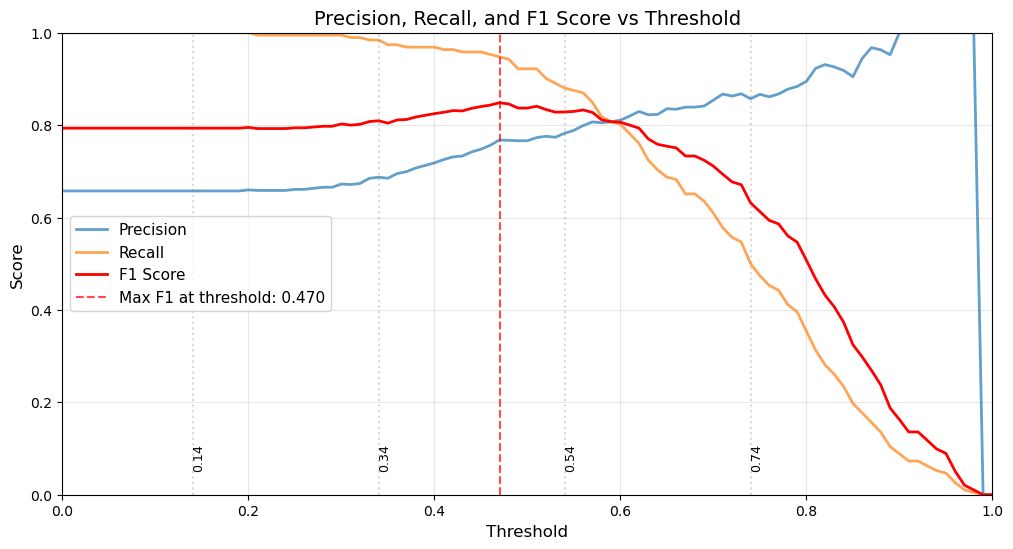


ANSWER: F1 is maximal at threshold closest to 0.54


In [15]:
# Plot F1 score, Precision, and Recall together
plt.figure(figsize=(12, 6))

plt.plot(thresholds, precisions, label='Precision', linewidth=2, alpha=0.7)
plt.plot(thresholds, recalls, label='Recall', linewidth=2, alpha=0.7)
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='red')

# Mark the maximum F1 threshold
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', 
            alpha=0.7, label=f'Max F1 at threshold: {max_f1_threshold:.3f}')

# Mark the answer options
for opt in answer_options_f1:
    plt.axvline(x=opt, color='gray', linestyle=':', alpha=0.3)
    plt.text(opt, 0.05, f'{opt}', rotation=90, verticalalignment='bottom', fontsize=9)

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, and F1 Score vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f"\n{'='*60}")
print(f"ANSWER: F1 is maximal at threshold closest to {best_option_f1}")
print(f"{'='*60}")

## Question 5: 5-Fold CV

Use KFold to evaluate the model on 5 different folds and compute the standard deviation of scores.

In [16]:
from sklearn.model_selection import KFold

# Combine train and validation sets to create df_full_train
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

print(f"Full training set size: {len(X_full_train)}")
print(f"Target distribution in full train: {y_full_train.mean():.4f}")

# Initialize KFold with specified parameters
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
fold_scores = []

# Iterate over different folds
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_full_train), 1):
    # Split the data into train and validation for this fold
    X_fold_train = X_full_train.iloc[train_idx]
    X_fold_val = X_full_train.iloc[val_idx]
    y_fold_train = y_full_train.iloc[train_idx]
    y_fold_val = y_full_train.iloc[val_idx]
    
    # Convert to dictionaries for DictVectorizer
    fold_train_dicts = X_fold_train.to_dict(orient='records')
    fold_val_dicts = X_fold_val.to_dict(orient='records')
    
    # Apply one-hot encoding
    fold_dv = DictVectorizer(sparse=False)
    X_fold_train_encoded = fold_dv.fit_transform(fold_train_dicts)
    X_fold_val_encoded = fold_dv.transform(fold_val_dicts)
    
    # Train the model with specified parameters
    fold_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    fold_model.fit(X_fold_train_encoded, y_fold_train)
    
    # Make predictions on validation fold
    y_fold_pred = fold_model.predict_proba(X_fold_val_encoded)[:, 1]
    
    # Calculate AUC for this fold
    fold_auc = roc_auc_score(y_fold_val, y_fold_pred)
    fold_scores.append(fold_auc)
    
    print(f"Fold {fold_idx}: AUC = {fold_auc:.4f}")

# Convert to numpy array for easier calculation
fold_scores = np.array(fold_scores)

# Calculate mean and standard deviation
mean_auc = fold_scores.mean()
std_auc = fold_scores.std()

print(f"\n{'='*60}")
print(f"Mean AUC across folds: {mean_auc:.4f}")
print(f"Standard deviation of AUC scores: {std_auc:.4f}")
print(f"{'='*60}")

# Check which answer option is closest
answer_options_std = [0.0001, 0.006, 0.06, 0.36]
print("\nAnswer options:")
for opt in answer_options_std:
    print(f"  {opt}")

# Find closest
closest_option = min(answer_options_std, key=lambda x: abs(x - std_auc))
print(f"\nThe standard deviation {std_auc:.4f} is closest to: {closest_option}")

Full training set size: 1169
Target distribution in full train: 0.6202
Fold 1: AUC = 0.8067
Fold 2: AUC = 0.8068
Fold 3: AUC = 0.8648
Fold 4: AUC = 0.8334
Fold 5: AUC = 0.8154

Mean AUC across folds: 0.8254
Standard deviation of AUC scores: 0.0220

Answer options:
  0.0001
  0.006
  0.06
  0.36

The standard deviation 0.0220 is closest to: 0.006


## Question 6: Hyperparameter Tuning

Use 5-Fold cross-validation to find the best parameter C by comparing mean scores and standard deviations.

In [17]:
# C values to test
c_values = [0.000001, 0.001, 1]

# Dictionary to store results for each C value
results = {}

print("Hyperparameter Tuning: Testing different C values\n")
print("="*70)

# Iterate over each C value
for C in c_values:
    print(f"\nTesting C = {C}")
    print("-"*70)
    
    # Initialize KFold with same parameters as before
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Store AUC scores for each fold
    c_fold_scores = []
    
    # Iterate over different folds
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_full_train), 1):
        # Split the data into train and validation for this fold
        X_fold_train = X_full_train.iloc[train_idx]
        X_fold_val = X_full_train.iloc[val_idx]
        y_fold_train = y_full_train.iloc[train_idx]
        y_fold_val = y_full_train.iloc[val_idx]
        
        # Convert to dictionaries for DictVectorizer
        fold_train_dicts = X_fold_train.to_dict(orient='records')
        fold_val_dicts = X_fold_val.to_dict(orient='records')
        
        # Apply one-hot encoding
        fold_dv = DictVectorizer(sparse=False)
        X_fold_train_encoded = fold_dv.fit_transform(fold_train_dicts)
        X_fold_val_encoded = fold_dv.transform(fold_val_dicts)
        
        # Train the model with current C value
        fold_model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        fold_model.fit(X_fold_train_encoded, y_fold_train)
        
        # Make predictions on validation fold
        y_fold_pred = fold_model.predict_proba(X_fold_val_encoded)[:, 1]
        
        # Calculate AUC for this fold
        fold_auc = roc_auc_score(y_fold_val, y_fold_pred)
        c_fold_scores.append(fold_auc)
        
        print(f"  Fold {fold_idx}: AUC = {fold_auc:.4f}")
    
    # Convert to numpy array for easier calculation
    c_fold_scores = np.array(c_fold_scores)
    
    # Calculate mean and standard deviation (rounded to 3 decimal digits)
    mean_score = round(c_fold_scores.mean(), 3)
    std_score = round(c_fold_scores.std(), 3)
    
    # Store results
    results[C] = {
        'mean': mean_score,
        'std': std_score,
        'scores': c_fold_scores
    }
    
    print(f"\n  Mean AUC: {mean_score}")
    print(f"  Std AUC:  {std_score}")

# Summary of all results
print("\n" + "="*70)
print("SUMMARY OF RESULTS")
print("="*70)
print(f"{'C Value':<15} {'Mean AUC':<15} {'Std AUC':<15}")
print("-"*70)
for C in c_values:
    print(f"{C:<15} {results[C]['mean']:<15} {results[C]['std']:<15}")

# Find the best C according to the rules:
# 1. Highest mean score
# 2. If tie, lowest std
# 3. If still tie, smallest C

max_mean = max(results[C]['mean'] for C in c_values)
best_c_candidates = [C for C in c_values if results[C]['mean'] == max_mean]

if len(best_c_candidates) == 1:
    best_C = best_c_candidates[0]
    print(f"\n✓ Best C value: {best_C} (highest mean score: {results[best_C]['mean']})")
else:
    # Check std among candidates with same mean
    min_std = min(results[C]['std'] for C in best_c_candidates)
    best_c_candidates = [C for C in best_c_candidates if results[C]['std'] == min_std]
    
    if len(best_c_candidates) == 1:
        best_C = best_c_candidates[0]
        print(f"\n✓ Best C value: {best_C} (tied on mean, lowest std: {results[best_C]['std']})")
    else:
        # Select smallest C
        best_C = min(best_c_candidates)
        print(f"\n✓ Best C value: {best_C} (tied on mean and std, smallest C)")

print("="*70)

Hyperparameter Tuning: Testing different C values


Testing C = 1e-06
----------------------------------------------------------------------
  Fold 1: AUC = 0.5896
  Fold 2: AUC = 0.5160
  Fold 3: AUC = 0.5369
  Fold 4: AUC = 0.5308
  Fold 5: AUC = 0.5428

  Mean AUC: 0.543
  Std AUC:  0.025

Testing C = 0.001
----------------------------------------------------------------------
  Fold 1: AUC = 0.8607
  Fold 2: AUC = 0.8402
  Fold 3: AUC = 0.8838
  Fold 4: AUC = 0.8712
  Fold 5: AUC = 0.8656

  Mean AUC: 0.864
  Std AUC:  0.014

Testing C = 1
----------------------------------------------------------------------
  Fold 1: AUC = 0.8067
  Fold 2: AUC = 0.8068
  Fold 3: AUC = 0.8648
  Fold 4: AUC = 0.8334
  Fold 5: AUC = 0.8154

  Mean AUC: 0.825
  Std AUC:  0.022

SUMMARY OF RESULTS
C Value         Mean AUC        Std AUC        
----------------------------------------------------------------------
1e-06           0.543           0.025          
0.001           0.864           0.014   

### Answer to Question 6

**The best C value is: 0.001**

Results summary:
- C = 0.000001: Mean AUC = 0.543, Std = 0.025
- **C = 0.001: Mean AUC = 0.864, Std = 0.014** ✓ (Best mean score)
- C = 1: Mean AUC = 0.825, Std = 0.022

C = 0.001 has the highest mean AUC score (0.864), so it is the best choice according to the selection criteria.